In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

import confirm.mini_imprint.bound.binomial as binomial

## Optimizing q for Exponential Holder Bound

In [3]:
def A(t, n):
    '''
    Numerically stable implementation of n * log(1 + e^t).
    '''
    return n * np.sum(np.maximum(t, 0) + np.log(1 + np.exp(-np.abs(t))))
    
def dA(t, n):
    return n * jax.nn.sigmoid(t)
    
def A_cp(t, n):
    return n * cp.sum(cp.logistic(t))

def opt_q_cp(n, theta_0, v, a):
    '''
    CVXPY implementation of finding optimal q
    '''    
    A0 = A(theta_0, n)
    q = cp.Variable(pos=True)
    objective_fn = (
        (A_cp(theta_0 + (q+1) * v, n) - A0)
        + a
    ) / (q + 1)
    objective = cp.Minimize(objective_fn)
    problem = cp.Problem(objective)
    problem.solve(qcp=True)
    return q.value + 1 

In [4]:
def phi_t(q, t, n, theta_0, v):
    '''
    Computes phi_t(q) defined as
        A(theta_0 + qv) - tq 
    '''
    return A(theta_0 + q * v, n) - t * q
    
def dphi_t(q, t, n, theta_0, v):
    '''
    Computes dphi_t(q)/dq given by
        A'(theta_0 + qv)^T v - t
    '''
    return jnp.sum(dA(theta_0 + q*v, n) * v) - t

def transform(u):
    return 1 + A(u, 1)
    
def dtransform(u):
    return dA(u, 1)
    
def inv_transform(q):
    return (q-1) + jnp.log(1 - jnp.exp(1-q))
    
def convex_feasible(
    t, n, theta_0, v, bound, 
    q0=2, tol=1e-7, max_tol=1e7, gamma_tol=1e7, max_iters=int(1e3),
):
    '''
    We say phi_t(q) is feasible if there exists q >= 1
    such that phi_t(q) <= bound, where bound == A(theta_0) - a.
    To unconstrain the minimization problem, we parametrize q = log(1 + e^u) + 1.
    We are using the Barzilai-Borwein method,
    so we must guarantee that the newly parametrized function is also convex and Lipschitz.

    Returns True if phi_t(q) is feasible.
    '''
    u0 = inv_transform(q0)

    u_prev = u0 - jnp.maximum(1, tol)
    q_prev = transform(u_prev)
    dphi_t_u_prev = dphi_t(q_prev, t, n, theta_0, v) * dtransform(u_prev)

    u = u0
    q = q0
    phi_t_u = phi_t(q, t, n, theta_0, v)
    dphi_t_u = dphi_t(q, t, n, theta_0, v) * dtransform(u)

    iter = 0
    while (phi_t_u > bound) and (jnp.abs(u - u_prev) > tol) and (iter < max_iters) and jnp.abs(u) <= max_tol:
        # compute descent quantities
        abs_delta_dphi_t_u = jnp.abs(dphi_t_u - dphi_t_u_prev)
        abs_delta_u = jnp.abs(u - u_prev)
        if abs_delta_u > gamma_tol * abs_delta_dphi_t_u:
            break
        gamma = abs_delta_u / abs_delta_dphi_t_u

        # update previous states
        u_prev = u
        q_prev = q
        dphi_t_u_prev = dphi_t_u
        
        # update current states
        u = u - gamma * dphi_t_u
        q = transform(u)
        phi_t_u = phi_t(q, t, n, theta_0, v)
        dphi_t_u = dphi_t(q, t, n, theta_0, v) * dtransform(u)

        iter += 1
        
    return q, phi_t_u, (phi_t_u <= bound), iter
    
def qcp_solve(n, theta_0, v, a, q0=2, bs_tol=1e-3, **kwargs):
    A0 = A(theta_0, n)
    bound = A0 - a

    # theoretical bounds that contain the minimum value
    lower = A(theta_0 + v, n) - A0
    upper = n * jnp.sum(jnp.maximum(v, 0))
    
    q = jnp.inf
    hint = q0

    while upper - lower >= bs_tol:
        mid = (upper + lower) / 2
        q_new, _, is_feasible, _ = convex_feasible(mid, n, theta_0, v, bound, q0=hint, **kwargs)    
        if is_feasible:
            upper = mid
            q, hint = q_new, q_new
        else:
            lower = mid
    
    return q

In [5]:
theta_0 = jnp.array([-2., -1., 0.3])
n = 350
a = -np.log(0.025)
v = 0.1 * jnp.array([0.4, 1, 0.2])

In [9]:
solver = binomial.ForwardQCPSolver(n)
solve_jit = jax.jit(solver.solve)

In [30]:
%%time
solve_jit(theta_0, v, a)

CPU times: user 123 µs, sys: 68 µs, total: 191 µs
Wall time: 202 µs


(DeviceArray(17.552002, dtype=float32),
 DeviceArray(17.55262, dtype=float32),
 DeviceArray(2.9566169, dtype=float32, weak_type=True),
 DeviceArray(2.9566169, dtype=float32, weak_type=True))

In [31]:
%%time 
q_opt_qcp = qcp_solve(n, theta_0, v, a)
q_opt_qcp

CPU times: user 38 ms, sys: 931 µs, total: 38.9 ms
Wall time: 38.4 ms


2.956617552773106

In [32]:
%%time
q_opt_qcp_cvxpy = opt_q_cp(n, theta_0, v, a)

CPU times: user 141 ms, sys: 2.69 ms, total: 144 ms
Wall time: 142 ms


/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


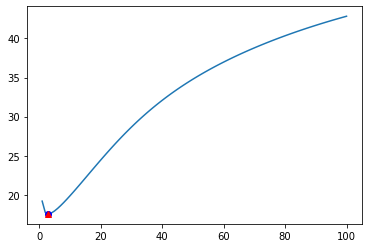

In [33]:
qs = jnp.linspace(1.0001, 100, 100)
phis = np.array([
    solver.objective(q, theta_0, v, a) for q in qs
]) 
plt.plot(qs, phis)
plt.plot(q_opt_qcp, solver.objective(q_opt_qcp, theta_0, v, a), 'bo')
plt.plot(q_opt_qcp_cvxpy, solver.objective(q_opt_qcp_cvxpy, theta_0, v, a), 'r^')

In [34]:
solver = binomial.ForwardQCPSolver(n)
solve_vmap_jit = jax.jit(jax.vmap(lambda t, v, a: solver.solve(t, v, a)[2], in_axes=(0, 0, None)))

def vectorize_run(key, m, d, a=-np.log(0.025), n=350):
    theta_0 = jax.random.normal(key, (m, d))
    _, key = jax.random.split(key)
    v = 0.001 * jax.random.normal(key, (m, d))
    return solve_vmap_jit(theta_0, v, a)

In [41]:
%%time
qs = vectorize_run(
    jax.random.PRNGKey(10),
    100000,
    3,
)

CPU times: user 5.67 s, sys: 42.6 ms, total: 5.71 s
Wall time: 5.7 s


2


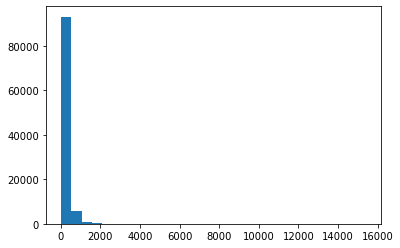

In [42]:
plt.hist(qs[~np.isinf(qs)], bins=30)
print(np.sum(np.isinf(qs)))

In [49]:
theta_0 = -1.
n = 350
f0 = 0.001
vs = np.linspace(0, 1, 1000)
solver = binomial.ForwardQCPSolver(n)
q_solver = jax.jit(jax.vmap(solver.solve, in_axes=(None, 0, None)))

In [50]:
qs = q_solver(theta_0, vs, -np.log(f0))

In [51]:
bounder = jax.vmap(binomial.q_holder_bound, in_axes=(0, None, None, 0, None))
bounds = bounder(qs, n, theta_0, vs, f0)

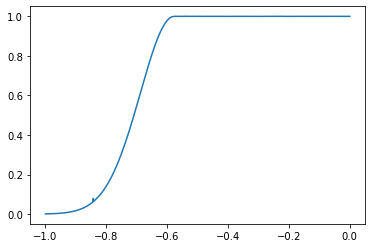

In [52]:
plt.plot(theta_0 + vs, bounds, ls='-')

## Optimizing q for Implicit Exponential Holder Bound

In [354]:
def objective_impl(n, theta_0, v, alpha, q):
    return (
        (A(theta_0 + q * v, n) - A(theta_0, n))
        - q * ((A(theta_0 + v, n) - A(theta_0, n)) + np.log(alpha))
    ) / (q-1)
    
def qcp_solve(n, theta_0, v, alpha):
    shift = (A(theta_0 + v, n) - A(theta_0, n)) + np.log(alpha)
    q = cp.Variable(pos=True)
    objective_fn = (
        (A_cp(theta_0 + (q+1) * v, n) - A(theta_0, n))
        - (q+1) * shift
    ) / q
    objective = cp.Minimize(objective_fn)
    problem = cp.Problem(objective)
    min = 0
    max = n * v - shift
    problem.solve(qcp=True, low=min+1e-6, high=max)
    return q.value + 1, problem.value

In [161]:
n = 350
theta_0 = -1
vs = np.linspace(0, 1, 100)
alpha = 0.025

/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


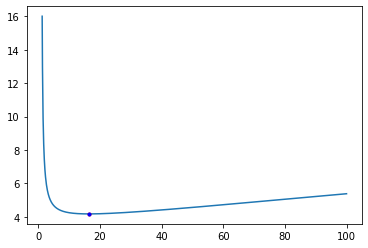

In [162]:
# cvxpy method
v = vs[2]
opt_q, opt_loss = qcp_solve(n, theta_0, v, alpha)

# brute force search method
qs = np.linspace(1.3, 100, 1000)
objs = np.array([objective(n, theta_0, v, alpha, q) for q in qs])
i_min = np.argmin(objs)

# plot
plt.plot(qs, objs)
plt.plot(qs[i_min], objs[i_min], 'r.')
plt.plot(opt_q, opt_loss, 'b.')